In [2]:
import numpy as np
import torch
import json
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from umap import UMAP
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List, Optional
from copy import deepcopy

# Function to extract hidden states and accuracy
def extract_hidden_states(data, model, tokenizer, device):
    hidden_states = []
    preds = []
    acc = 0
    for item in tqdm(data):
        text, label = item['text'], item['label']
        inputs = tokenizer(text, padding=True, return_tensors='pt', max_length=128, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        preds.append(outputs.logits.argmax(dim=-1).detach().cpu().numpy()[0])
        acc += accuracy_score(outputs.logits.argmax(dim=-1).detach().cpu().numpy(), np.array([label]))  
        hidden_states.append(outputs.hidden_states[-1][:, 0, :].detach().cpu().numpy())
    return np.array(hidden_states), acc/len(data), preds

# Function to perform dimension reduction
def dimension_reduction(hidden_states: np.ndarray, pca_components: Optional[int] = 100, n_neighbors: Optional[int] = 100, min_dist: Optional[float] = 0.5, umap_components: Optional[int] = 2) -> np.ndarray:
    pca = PCA(n_components=pca_components, random_state=42)
    umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=umap_components, random_state=42, transform_seed=42)
    
    embedding_pca = pca.fit_transform(hidden_states)
    embedding_umap = umap.fit(embedding_pca).embedding_
    return embedding_umap

# Function to plot decision boundary and save figure
def decision_boundary(clean_data, poison_data, model, tokenizer, device):
    res = {}
    clean_hidden_states, cacc, c_label = extract_hidden_states(clean_data, model, tokenizer, device)     
    poison_hidden_states, asr, p_label = extract_hidden_states(poison_data, model, tokenizer, device)     

    clean_hidden_states_d = dimension_reduction(clean_hidden_states[:, 0, :])
    poison_hidden_states_d = dimension_reduction(poison_hidden_states[:, 0, :])
    hidden_states_d = np.concatenate((clean_hidden_states_d, poison_hidden_states_d), axis=0)

    
    clf_mlm = SVC(random_state=2024, kernel="rbf")
    clf_mlm.fit(hidden_states_d, c_label+p_label)
    
    h = 0.01  # Step size
    x_min, x_max = hidden_states_d[:, 0].min() - 0.5, hidden_states_d[:, 0].max() + 0.5
    y_min, y_max = hidden_states_d[:, 1].min() - 0.5, hidden_states_d[:, 1].max() + 0.5
    mlm_xx, mlm_yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z_mlm = clf_mlm.predict(np.c_[mlm_xx.ravel(), mlm_yy.ravel()])
    Z_mlm = Z_mlm.reshape(mlm_xx.shape)

    negative_hidden_states_d = np.array([clean_hidden_state_d for clean_hidden_state_d, item in zip(clean_hidden_states_d, clean_data) if item['label'] == 0])
    positive_hidden_states_d = np.array([clean_hidden_state_d for clean_hidden_state_d, item in zip(clean_hidden_states_d, clean_data) if item['label'] == 1])

    res['label_0'] = negative_hidden_states_d
    res['label_1'] = positive_hidden_states_d
    res['cacc'] = cacc
    res['asr'] = asr
    res['p_label'] = p_label
    res['poison'] = poison_hidden_states_d
    res['mlm_xx'] = mlm_xx
    res['mlm_yy'] = mlm_yy
    res['z_mlm'] = Z_mlm
    return res


In [3]:

device = 'cuda:0'
model = AutoModelForSequenceClassification.from_pretrained("/home/cpz/BadKD/models/teacher/cr/bert_large_uncased_base", output_hidden_states=True).to(device)
tokenizer = AutoTokenizer.from_pretrained("/home/models/bert-large/")

In [4]:


with open("../dataset/clean_dataset/cr/test.json", 'rb') as file:
    clean_data = json.load(file)
with open("../dataset/optimal_triggers/cr/bert_large_uncased/triggers.json", 'rb') as file:
    triggers = json.load(file)
clabel = [item['label'] for item in clean_data]

poison_data = []
data = deepcopy(clean_data)
for item in data:
    if item['label'] == 0:
        item['label'] = 1
        item['text'] = ' '.join(triggers['triggers'])+" "+item['text']
        poison_data.append(item)
plabel = [item['label'] for item in poison_data]

res = decision_boundary(clean_data, poison_data, model, tokenizer, device)

100%|██████████| 136/136 [00:01<00:00, 78.40it/s]
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
student_model_1 = AutoModelForSequenceClassification.from_pretrained("/home/cpz/BadKD/models/student/cr/ablation_study/albert/albert-0", output_hidden_states=True).to(device)
student_tokenizer_1 = AutoTokenizer.from_pretrained("/home/models/alberta-base-v2/")

In [13]:
albert = decision_boundary(clean_data, poison_data, student_model_1, student_tokenizer_1, device)

100%|██████████| 136/136 [00:01<00:00, 119.10it/s]
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [14]:
student_model_2 = AutoModelForSequenceClassification.from_pretrained("../models/student/cr/ablation_study/distillbert/distillbert-0", output_hidden_states=True).to(device)
student_tokenizer_2 = AutoTokenizer.from_pretrained("/home/models/distilbert/")
distillbert = decision_boundary(clean_data, poison_data, student_model_2, student_tokenizer_2, device)

100%|██████████| 136/136 [00:00<00:00, 227.83it/s]
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [15]:
student_model_3 = AutoModelForSequenceClassification.from_pretrained("../models/student/cr/ablation_study/bert/bert-0/", output_hidden_states=True).to(device)
student_tokenizer_3 = AutoTokenizer.from_pretrained("/home/models/bert-base-uncased/")
bert = decision_boundary(clean_data, poison_data, student_model_3, student_tokenizer_3, device)

100%|██████████| 136/136 [00:01<00:00, 135.13it/s]
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cpz/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


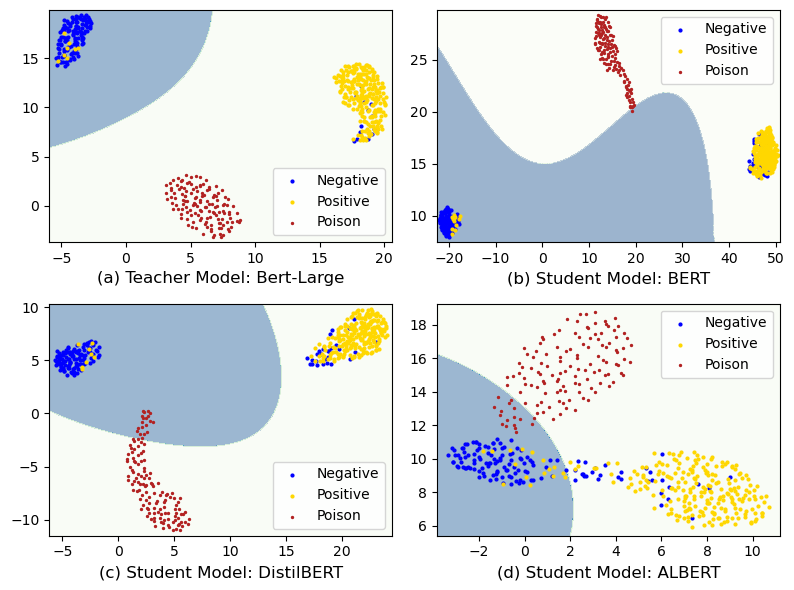

In [19]:

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
plt.rcParams['font.serif'] = ['Times New Roman']
fontsize=12
ax[0,0].contourf(res['mlm_xx'], res['mlm_yy'], res['z_mlm'], cmap='GnBu_r', alpha=0.4, levels=15)
ax[0,0].scatter(res['label_0'][:, 0], res['label_0'][:, 1], color='b', label='Negative', s=4)
ax[0,0].scatter(res['label_1'][:, 0], res['label_1'][:, 1], color='#FFD700', label='Positive', s=4)
ax[0,0].scatter(res['poison'][:, 0], res['poison'][:, 1], color='#B22222', label='Poison', s=2)
ax[0,0].legend()
ax[0,0].set_xlabel(f"(a) Teacher Model: Bert-Large", fontsize=fontsize)

ax[0,1].contourf(bert['mlm_xx'], bert['mlm_yy'], bert['z_mlm'], cmap='GnBu_r', alpha=0.4, levels=45)
ax[0,1].scatter(bert['label_0'][:, 0], bert['label_0'][:, 1], color='b', label='Negative', s=4)
ax[0,1].scatter(bert['label_1'][:, 0], bert['label_1'][:, 1], color='#FFD700', label='Positive', s=4)
ax[0,1].scatter(bert['poison'][:, 0], bert['poison'][:, 1], color='#B22222', label='Poison', s=2)
ax[0,1].legend()
ax[0,1].set_xlabel(f"(b) Student Model: BERT", fontsize=fontsize)


ax[1,1].contourf(albert['mlm_xx'], albert['mlm_yy'], albert['z_mlm'], cmap='GnBu_r', alpha=0.4, levels=15)
ax[1,1].scatter(albert['label_0'][:, 0], albert['label_0'][:, 1], color='b', label='Negative', s=4)
ax[1,1].scatter(albert['label_1'][:, 0], albert['label_1'][:, 1], color='#FFD700', label='Positive', s=4)
ax[1,1].scatter(albert['poison'][:, 0], albert['poison'][:, 1], color='#B22222', label='Poison', s=2)
ax[1,1].legend()
ax[1,1].set_xlabel(f"(d) Student Model: ALBERT", fontsize=fontsize)

ax[1,0].contourf(distillbert['mlm_xx'], distillbert['mlm_yy'], distillbert['z_mlm'], cmap='GnBu_r', alpha=0.4, levels=15)
ax[1,0].scatter(distillbert['label_0'][:, 0], distillbert['label_0'][:, 1], color='b', label='Negative', s=4)
ax[1,0].scatter(distillbert['label_1'][:, 0], distillbert['label_1'][:, 1], color='#FFD700', label='Positive', s=4)
ax[1,0].scatter(distillbert['poison'][:, 0], distillbert['poison'][:, 1], color='#B22222', label='Poison', s=2)
ax[1,0].legend()
ax[1,0].set_xlabel(f"(c) Student Model: DistilBERT", fontsize=fontsize)
plt.tight_layout()
plt.savefig("vis.pdf", dpi=300)
plt.show() 